In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

%matplotlib inline


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [488]:
LEARNING_RATE = 10e-5

tf.reset_default_graph()

initializer = tf.contrib.layers.variance_scaling_initializer()

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

d1 = tf.layers.dense(x, units=1024,  activation=tf.nn.relu, kernel_initializer=initializer, name="d1")
dropout1 = tf.layers.dropout(d1, rate=0.1, training=is_training, name="dropout1")
d2 = tf.layers.dense(dropout1, units=1024, activation=tf.nn.relu, kernel_initializer=initializer, name="d2")
ln1 = tf.contrib.layers.layer_norm(d2)
d3 = tf.layers.dense(ln1, units=1024,  activation=tf.nn.relu, kernel_initializer=initializer, name="d3")
dropout2 = tf.layers.dropout(d3, rate=0.1, training=is_training, name="dropout2")
ln2 = tf.contrib.layers.layer_norm(dropout2)
d4 = tf.layers.dense(ln2, units=1024,  activation=tf.nn.relu, kernel_initializer=initializer, name="d4")
ln3 = tf.contrib.layers.layer_norm(d4)
d5 = tf.layers.dense(ln3, units=1024,  activation=tf.nn.relu, kernel_initializer=initializer, name="d5")
d6 = tf.layers.dense(d5, units=10, name="d6")
y  = tf.nn.softmax(d6, name="y")

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



sess=tf.Session()
tf.global_variables_initializer().run(session=sess)



In [489]:
saver = tf.train.Saver()
CHECK_POINT_FILE_NAME = "./hw3_1.ckpt"
try:
    saver.restore(sess, CHECK_POINT_FILE_NAME)
except:
    pass


INFO:tensorflow:Restoring parameters from ./hw3_1.ckpt


In [79]:
TRAIN_STEPS = 2000

for i in range(TRAIN_STEPS+1):
    batch = mnist.train.next_batch(128)
    _, loss_value = sess.run((train_step, loss), feed_dict={x: batch[0], y_: batch[1]})
    if i % 500 == 0:
        is_training = False
        print('Training Step:' + str(i) + '  Accuracy =  ' + 
              str(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})) + 
              '  Loss =  ' + str(loss_value))
        is_training = True

        

Training Step:0  Accuracy =  0.9653  Loss =  1.5027733
Training Step:500  Accuracy =  0.9686  Loss =  1.4704438
Training Step:1000  Accuracy =  0.9709  Loss =  1.4858124
Training Step:1500  Accuracy =  0.9736  Loss =  1.4916209
Training Step:2000  Accuracy =  0.9693  Loss =  1.4647149


In [29]:
save_path = saver.save(sess, CHECK_POINT_FILE_NAME)

In [471]:
saver.restore(sess, CHECK_POINT_FILE_NAME)

INFO:tensorflow:Restoring parameters from ./hw3_1.ckpt


In [490]:
# Run the Accuracy before performing copression (Baseline Performance)
sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.9591

In [252]:
# Calculate W hat based on different D value
D_range = [10, 20, 50, 100, 200, 500, -1]

Whs_list = {}
target_weights = ["d1/kernel:0", "d2/kernel:0", "d3/kernel:0", "d4/kernel:0", "d5/kernel:0", "d6/kernel:0"]
target_bias = ["d1/bias:0", "d2/bias:0", "d3/bias:0", "d4/bias:0", "d5/bias:0", "d6/bias:0"]

bias_list = {}

for d in D_range:
    Whs_list[d] = {}

for var in tf.trainable_variables():
#     print(var.name)
    if var.name in target_weights:
        s, u, v = tf.linalg.svd(var, full_matrices=False)        
        s_diag = tf.linalg.diag(s)
        s_val = sess.run(s_diag)
        print(var.shape, s_val.shape, u_val.shape, v_val.shape)
        for d in D_range: 
            s_h = np.copy(s_val.reshape(1, -1)).reshape(s_val.shape)
            if d > 0:
                # set index > d to zero
                # don't bother to set zero to u and v for col or row > D
                # since as long as we turncate diag matrix, the element of W hat 
                # which row/col > D will be zero.
                s_h[:,d:] = 0
                s_h[d:,:] = 0
            wh = tf.matmul(u, tf.matmul(s_h, v, adjoint_b=True))
            Whs_list[d][var.name] = sess.run(wh)
    elif var.name in target_bias:
        bias_list[var.name] = sess.run(var)
        


(784, 1024) (784, 784) (1024, 1024) (1024, 1024)
(1024, 1024) (1024, 1024) (1024, 1024) (1024, 1024)
(1024, 1024) (1024, 1024) (1024, 1024) (1024, 1024)
(1024, 1024) (1024, 1024) (1024, 1024) (1024, 1024)
(1024, 1024) (1024, 1024) (1024, 1024) (1024, 1024)
(1024, 10) (10, 10) (1024, 1024) (1024, 1024)


In [417]:
# Check the weight and bias shape
print(Whs_list[-1]["d1/kernel:0"].shape)
print(bias_list["d1/bias:0"].shape)

print(Whs_list[-1]["d5/kernel:0"].shape)
print(bias_list["d5/bias:0"].shape)

print(Whs_list[-1]["d6/kernel:0"].shape)
print(bias_list["d6/bias:0"].shape)

(784, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 10)
(10,)


In [253]:
# Give D, calculate the accuracy based on 
def test_acc(d):
    
    whs = Whs_list[d]

    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])
    d1 = tf.layers.dense(x, units=1024,  activation=tf.nn.relu, trainable=False, \
                         kernel_initializer=tf.constant_initializer(whs["d1/kernel:0"]), \
                         bias_initializer=tf.constant_initializer(bias_list["d1/bias:0"]))
    d2 = tf.layers.dense(d1, units=1024, activation=tf.nn.relu, trainable=False, \
                         kernel_initializer=tf.constant_initializer(whs["d2/kernel:0"]), \
                         bias_initializer=tf.constant_initializer(bias_list["d2/bias:0"]))
    ln1 = tf.contrib.layers.layer_norm(d2)
    d3 = tf.layers.dense(ln1, units=1024,  activation=tf.nn.relu, trainable=False, \
                         kernel_initializer=tf.constant_initializer(whs["d3/kernel:0"]), \
                         bias_initializer=tf.constant_initializer(bias_list["d3/bias:0"]))
    ln2 = tf.contrib.layers.layer_norm(d3)
    d4 = tf.layers.dense(ln2, units=1024,  activation=tf.nn.relu, trainable=False, \
                         kernel_initializer=tf.constant_initializer(whs["d4/kernel:0"]), \
                         bias_initializer=tf.constant_initializer(bias_list["d4/bias:0"]))
    ln3 = tf.contrib.layers.layer_norm(d4)
    d5 = tf.layers.dense(ln3, units=1024,  activation=tf.nn.relu, trainable=False, \
                         kernel_initializer=tf.constant_initializer(whs["d5/kernel:0"]), \
                         bias_initializer=tf.constant_initializer(bias_list["d5/bias:0"]))
    d6 = tf.layers.dense(d5, units=10, trainable=False, \
                         kernel_initializer=tf.constant_initializer(whs["d6/kernel:0"]), \
                         bias_initializer=tf.constant_initializer(bias_list["d6/bias:0"]))
    y  = tf.nn.softmax(d6)

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    sess=tf.Session()
    tf.global_variables_initializer().run(session=sess)
    acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    print("D : {}, accuracy : {}".format(d, acc)) 
    return acc

    

In [254]:
acc_results = [ test_acc(d) for d in D_range ]

D : 10, accuracy : 0.10779999941587448
D : 20, accuracy : 0.17020000517368317
D : 50, accuracy : 0.39879998564720154
D : 100, accuracy : 0.6262999773025513
D : 200, accuracy : 0.7976999878883362
D : 500, accuracy : 0.9585999846458435
D : -1, accuracy : 0.9707000255584717


Text(0, 0.5, 'Accuracy')

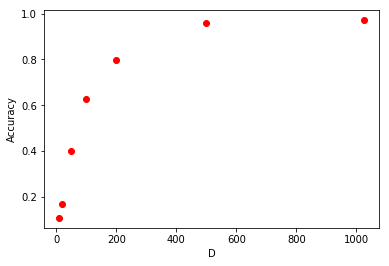

In [255]:
# Draw the chart to show the relation between D and accuracy
x = D_range[:]
x[-1] = 1024
plt.plot(x, acc_results, 'ro')

plt.xlabel('D')
plt.ylabel('Accuracy')


In [491]:
# Now we build network with using fixed D = 20

FIX_D = 20

de_u = {}
de_v = {}

for var in tf.trainable_variables():
    if var.name in target_weights:
        s, u, v = tf.linalg.svd(var, full_matrices=False)        
        s_diag = tf.linalg.diag(s)
        v2 = tf.matmul(v, s_diag, adjoint_b=True)  
        u_val = sess.run(u)
        v2_val = sess.run(v)
        u_val = u_val[:, :FIX_D]
        v2_val = v2_val[:, :FIX_D]
        print(u_val.shape, v2_val.shape)
        print(tf.matmul(u_val, v2_val, adjoint_b=True).shape)
        de_u[var.name] = u_val
        de_v[var.name] = v2_val

(784, 20) (1024, 20)
(784, 1024)
(1024, 20) (1024, 20)
(1024, 1024)
(1024, 20) (1024, 20)
(1024, 1024)
(1024, 20) (1024, 20)
(1024, 1024)
(1024, 20) (1024, 20)
(1024, 1024)
(1024, 10) (10, 10)
(1024, 10)


In [492]:
# Build the network based on U V2

# tf.reset_default_graph()

def fine_tune_model():
        
    with tf.variable_scope("fine_tune_model", reuse=tf.AUTO_REUSE):
    
        x = tf.placeholder(tf.float32, [None, 784])
        y_ = tf.placeholder(tf.float32, [None, 10])

        U1 = tf.get_variable("ft_U1", [784, FIX_D], initializer = tf.constant_initializer(de_u["d1/kernel:0"]))
        V1 = tf.get_variable("ft_V1", [1024, FIX_D], initializer = tf.constant_initializer(de_v["d1/kernel:0"]))    
        b1 = tf.Variable(bias_list["d1/bias:0"])

        U2 = tf.get_variable("ft_U2", [1024, FIX_D], initializer = tf.constant_initializer(de_u["d2/kernel:0"]))
        V2 = tf.get_variable("ft_V2", [1024, FIX_D], initializer = tf.constant_initializer(de_v["d2/kernel:0"]))    
        b2 = tf.Variable(bias_list["d2/bias:0"])
        
        U3 = tf.get_variable("ft_U3", [1024, FIX_D], initializer = tf.constant_initializer(de_u["d3/kernel:0"]))
        V3 = tf.get_variable("ft_V3", [1024, FIX_D], initializer = tf.constant_initializer(de_v["d3/kernel:0"]))    
        b3 = tf.Variable(bias_list["d3/bias:0"])
        
        U4 = tf.get_variable("ft_U4", [1024, FIX_D], initializer = tf.constant_initializer(de_u["d4/kernel:0"]))
        V4 = tf.get_variable("ft_V4", [1024, FIX_D], initializer = tf.constant_initializer(de_v["d4/kernel:0"]))    
        b4 = tf.Variable(bias_list["d4/bias:0"])
        
        U5 = tf.get_variable("ft_U5", [1024, FIX_D], initializer = tf.constant_initializer(de_u["d5/kernel:0"]))
        V5 = tf.get_variable("ft_V5", [1024, FIX_D], initializer = tf.constant_initializer(de_v["d5/kernel:0"]))    
        b5 = tf.Variable(bias_list["d5/bias:0"])
            
        U6 = tf.get_variable("ft_U6", [1024, 10], initializer = tf.constant_initializer(de_u["d6/kernel:0"]))
        V6 = tf.get_variable("ft_V6", [10, 10], initializer = tf.constant_initializer(de_v["d6/kernel:0"]))    
        b6 = tf.Variable(bias_list["d6/bias:0"])

        d1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x, tf.matmul(U1, V1, adjoint_b=True)), b1))
        d2 = tf.nn.relu(tf.nn.bias_add(tf.matmul(d1, tf.matmul(U2, V2, adjoint_b=True)), b2))
        ln1 = tf.contrib.layers.layer_norm(d2)    
        d3 = tf.nn.relu(tf.nn.bias_add(tf.matmul(ln1, tf.matmul(U3, V3, adjoint_b=True)), b3))
        ln2 = tf.contrib.layers.layer_norm(d3)
        d4 = tf.nn.relu(tf.nn.bias_add(tf.matmul(ln2, tf.matmul(U4, V4, adjoint_b=True)), b4))
        ln3 = tf.contrib.layers.layer_norm(d4)
        d5 = tf.nn.relu(tf.nn.bias_add(tf.matmul(ln3, tf.matmul(U5, V5, adjoint_b=True)), b5))
        d6 = tf.nn.relu(tf.nn.bias_add(tf.matmul(d5, tf.matmul(U6, V6, adjoint_b=True)), b6))
        y  = tf.nn.softmax(d6)

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
        
        train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

        sess=tf.Session()
        tf.global_variables_initializer().run(session=sess)
        
        return (sess, accuracy, x, y_, train_step, loss)



In [493]:
(sess, accuracy, x, y_, train_step, loss) = fine_tune_model()

acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print("accuracy : {}".format(acc)) 


accuracy : 0.12460000067949295


In [496]:
# fine-tune the new network
TRAIN_STEPS = 4000

for i in range(TRAIN_STEPS+1):
    batch = mnist.train.next_batch(128)
    _, loss_value = sess.run((train_step, loss), feed_dict={x: batch[0], y_: batch[1]})
    if i % 500 == 0:
        is_training = False
        print('Training Step:' + str(i) + '  Accuracy =  ' + 
              str(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})) + 
              '  Loss =  ' + str(loss_value))
        is_training = True

        

Training Step:0  Accuracy =  0.9508  Loss =  1.5148978
Training Step:500  Accuracy =  0.9549  Loss =  1.532229
Training Step:1000  Accuracy =  0.9537  Loss =  1.5188977
Training Step:1500  Accuracy =  0.9551  Loss =  1.5048193
Training Step:2000  Accuracy =  0.9591  Loss =  1.5033535


In [497]:
acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print("accuracy : {}".format(acc)) 


accuracy : 0.9591000080108643
